In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Bell_Amundsen_Extent = pd.read_excel(filepath, sheet_name='Bell-Amundsen-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Bell_Amundsen_Extent)
fp.date_time(Bell_Amundsen_Extent)

,Extent,Date
0,1179855.894,1979-01-01
1,879585.254,1979-02-01
2,791619.096,1979-03-01
3,1254912.071,1979-04-01
4,1620142.247,1979-05-01
...,...,...
533,1556568.455,2023-06-01
534,1917507.979,2023-07-01
535,2601630.327,2023-08-01
536,2534223.780,2023-09-01


In [5]:
scaler = MinMaxScaler()
Bell_Amundsen_Extent['Extent'] = scaler.fit_transform(Bell_Amundsen_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 11
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Bell_Amundsen_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((516, 12, 1), (516,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Bell_Amund_model_LT11/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 13s 152ms/step - loss: 0.2434 - root_mean_squared_error: 0.4933 - val_loss: 0.1849 - val_root_mean_squared_error: 0.4300
Epoch 2/50
53/53 [==============================] - 8s 151ms/step - loss: 0.1272 - root_mean_squared_error: 0.3567 - val_loss: 0.0943 - val_root_mean_squared_error: 0.3071
Epoch 3/50
53/53 [==============================] - 7s 137ms/step - loss: 0.0770 - root_mean_squared_error: 0.2774 - val_loss: 0.0816 - val_root_mean_squared_error: 0.2856
Epoch 4/50
53/53 [==============================] - 7s 143ms/step - loss: 0.0693 - root_mean_squared_error: 0.2632 - val_loss: 0.0755 - val_root_mean_squared_error: 0.2747
Epoch 5/50
53/53 [==============================] - 8s 148ms/step - loss: 0.0644 - root_mean_squared_error: 0.2538 - val_loss: 0.0705 - val_root_mean_squared_error: 0.2655
Epoch 6/50
53/53 [==============================] - 7s 132ms/step - loss: 0.0597 - root_mean_squared_error: 0.2443 - val_loss: 0.0631 - val

53/53 [==============================] - 1s 24ms/step - loss: 0.0146 - root_mean_squared_error: 0.1207 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0996
Epoch 34/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0134 - root_mean_squared_error: 0.1156 - val_loss: 0.0102 - val_root_mean_squared_error: 0.1012
Epoch 35/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0125 - root_mean_squared_error: 0.1120 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1120
Epoch 36/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0133 - root_mean_squared_error: 0.1151 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 37/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0123 - root_mean_squared_error: 0.1111 - val_loss: 0.0096 - val_root_mean_squared_error: 0.0982
Epoch 38/50
53/53 [==============================] - 1s 24ms/step - loss: 0.0140 - root_mean_squared_error: 0.1185 - val_loss: 0.0096 - val_root_mean_sq

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

3.132544247309367 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

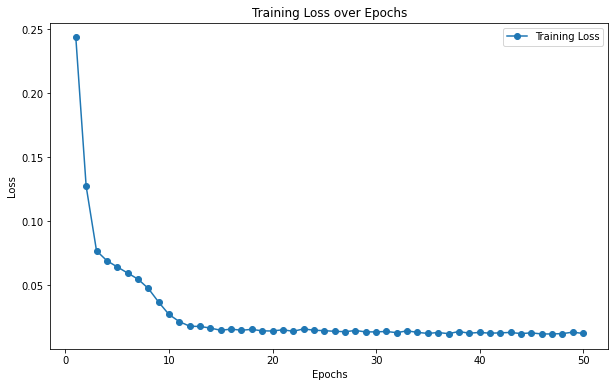

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

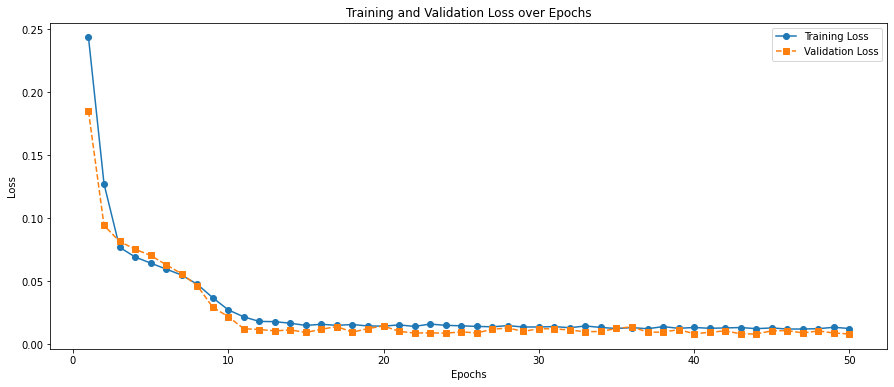

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Bell_Amund_model_LT11/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 10ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.07391258037314412
MAE : 0.059656623774431365


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,5.419949e+05,439855.813
1,7.618291e+05,807857.307
2,1.109197e+06,1184280.145
3,1.496342e+06,1468308.405
4,1.849370e+06,1540851.607
5,2.033969e+06,1989099.836
6,2.115263e+06,2096990.761
7,2.081673e+06,2080961.032
8,1.704321e+06,1695704.661
9,1.305130e+06,1533888.370


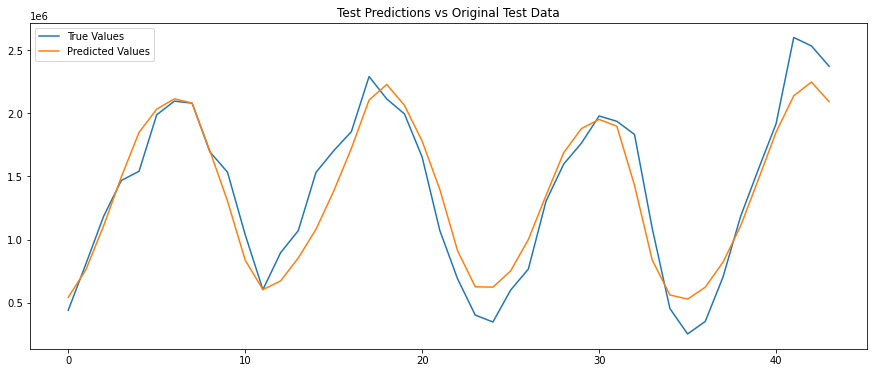

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 11ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

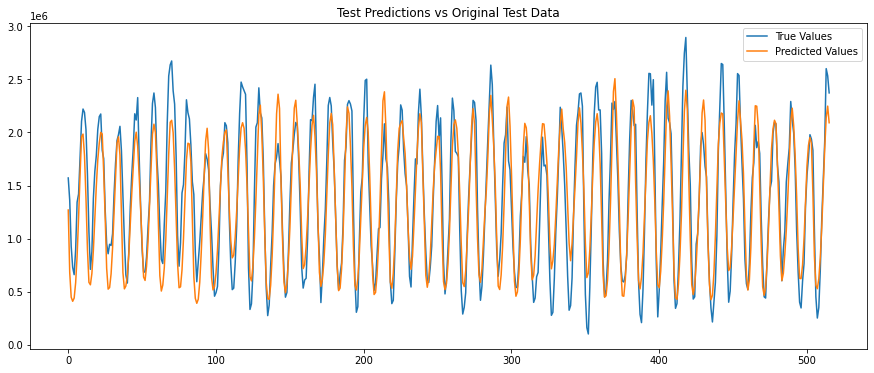

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()